In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import boxcox
from scipy.stats import normaltest
from scipy.stats import zscore
from sklearn.metrics import mean_squared_error as mse
import xgboost as xgb
from xgboost import plot_importance
from math import log
from math import sqrt
import calendar
import datetime
import holidays

## Data Preparation

The data challenge presented is to build a model that can forecast the number of entries system wide each day in December, given time series data from January through November. In its current state, the data identifies individual turnstiles at each station through a triple of (C.A, UNIT, SCP), where C.A is control area, UNIT is unit ID, and SCP is subunit/channel/position. 

As we are only concerned with entries, and no data is provided to create a link between entries and exits, exits have been dropped from the dataset. Moreover, we gain a few new columns. First a column with integers denoting which month we are in, a column for day of the week, composed of strings, to denote which day of the week it is, a binary column to denote if the day presented is a holiday or not, and a column of integers denoting a unique code to each turnstile. These four columns will help with organizing the data for computations and will help with understanding themes within the dataset (potentially).

One last important column is total entries for each day. The functions below are built with the purpose to find these values, and to organize the data in a way that will be most useful for data visualization and modeling later on. They produce a new dataframe that contains columns DATE (string), MONTH (int), DOW (Day of Week; string), HOLIDAY (binary int), ENTRIES (int).

In [2]:
def make_identifier(data):
    """
    Purpose of this function is to create a column that will uniquely identify a turnstile. In the dataset, the way
    turnstiles are identified is by a trip (C.A, SCP, UNIT). Putting in this column makes it so we can call a single value
    to find the turnstile.
    """
    data_id = data.apply(lambda x: '_'.join(map(str, x)), axis=1)
    return pd.factorize(data_id)[0]

In [3]:
def date_to_month(date):
    """
    Input mm-dd-yy (month-day-year). Extract and return the month from input date.
    """
    return int(date.split('-')[1])

In [4]:
def add_hourly_entries(df):
    """
    A single turnstile machine is identified by the trip (C.A, SCP, UNIT). The ENTRIES column denotes the cumulative
    total for a single turnstile per row, since they have been collecting data. We want to have a new column that denotes
    for a particular 4-hour interval, how many people went through a turnstile.
    
    This function creates said column, calculating the difference between the ENTRIES in the current row and the previous
    row, filling NaNs with 0s.
    """
    
    HOURLY_ENTRIES = df.ENTRIES - df.ENTRIES.shift(1) 
    df['HOURLY_ENTRIES'] = HOURLY_ENTRIES.fillna(0)
    return df

In [5]:
def findDay(date):
    """
    Day of week may be an important feature. So this function grabs what day of the week it is.
    """
    day = datetime.datetime.strptime(date, '%Y-%m-%d').weekday() 
    return (calendar.day_name[day])

In [6]:
us_holidays = holidays.UnitedStates(years = 2016)
def holiday(date):
    """
    Purpose is to make a new column that is binary, where 1 means there is a holiday and 0 means there is not.
    """
    if date in us_holidays:
        return 1
    else:
        return 0

In [7]:
def clean_data(data):
    """
    When finding entries system wide the first time, I noticed some irregularities. Some of the system wide entry totals
    were either negative or way too large. The purpose of this function is to seek out and eliminate those irregularities
    with averages from the group identified by ('SCP', 'MONTH').
    
    We assume that it takes about 1 second for someone to go through a turnstile, so about 14400 runs through a turnstile
    can happen at max each day. For a buffer, we declare the max as 20000. Also, we know that there cannot be negative
    turnstile numbers, so we detect those too.
    """
    data['HOURLY_ENTRIES'] = data.groupby(['SCP','MONTH']).HOURLY_ENTRIES.transform(
    lambda x: np.where((x<0)|(x>20000),x.mask((x<0)|(x>20000)).mean(),x))
    return data

In [8]:
def create_lists_for_each_day(data):
    """
    This function creates a list to be turned into a dataframe, and will operate as the dataset for our exploration and
    modeling. Note that the important features DATE, MONTH, DOW, HOLIDAY, and ENTRIES are included for both exploratory
    and data wrangling purposes.
    """
    total_entries_each_day = []
    dates = data.DATE.unique()
    ids = data.ID.unique()
    for date in dates:
        pick_date = data[data['DATE'] == date]
        entries = 0
        for data_id in ids:
            entry = pick_date[pick_date['ID'] == data_id]['HOURLY_ENTRIES'].sum()
            entries += entry
        total_entries_each_day.append([date, 
                                       pick_date['MONTH'].values[0], 
                                       pick_date['DOW'].values[0], 
                                       pick_date['HOLIDAY'].values[0], 
                                       int(entries)])
    return total_entries_each_day

In [9]:
def create_new_dataframe(old_data):
    """
    This function operates like a 'run' function that applies all the above functions to make the data wrangling,
    data cleaning, and data aggregating come togethter into a new dataframe.
    """
    data = old_data.copy()
    data['ID'] = make_identifier(data[['C.A', 'UNIT', 'SCP']] )
    data['MONTH'] = data['DATE'].map(date_to_month)
    data['DOW'] = data['DATE'].map(findDay)
    data['HOLIDAY'] = data['DATE'].map(holiday)
    data = data.groupby(['ID']).apply(add_hourly_entries)
    data = clean_data(data)
    total_each_day = create_lists_for_each_day(data)
    time_series_data = pd.DataFrame(data = total_each_day, columns = ['DATE', 'MONTH', 'DOW', 'HOLIDAY', 'ENTRIES'])
    
    return time_series_data

In [10]:
data = pd.read_csv('turnstiles_2016.csv')
data.head()

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,C.A,UNIT,SCP,STATION,LINENAME,DATE,TIME,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,456NQRW,2016-01-02,03:00:00,5991458.0,1849152.0
1,A002,R051,02-00-00,59 ST,456NQRW,2016-01-02,07:00:00,5991537.0,1849161.0
2,A002,R051,02-00-00,59 ST,456NQRW,2016-01-02,11:00:00,5991794.0,1849240.0
3,A002,R051,02-00-00,59 ST,456NQRW,2016-01-02,15:00:00,5992215.0,1849340.0
4,A002,R051,02-00-00,59 ST,456NQRW,2016-01-02,19:00:00,5992488.0,1849403.0


In [11]:
#Checking if the data has any nulls for entries
data.isnull().sum()

C.A              0
UNIT             0
SCP              0
STATION          0
LINENAME         0
DATE             0
TIME             0
ENTRIES          0
EXITS       955531
dtype: int64

In [12]:
time_series_data = create_new_dataframe(data)

In [13]:
time_series_data.head()

,DATE,MONTH,DOW,HOLIDAY,ENTRIES
0,2016-01-02,1,Saturday,0,4445069
1,2016-01-03,1,Sunday,0,3721660
2,2016-01-04,1,Monday,0,7672778
3,2016-01-05,1,Tuesday,0,7687661
4,2016-01-06,1,Wednesday,0,8000411


In [14]:
time_series_data.to_csv('formatted_cleaned_daily_data.csv', index = False)

## Splitting the Data into Train and Test

Before developing our models, we need to establish quality train and test sets. The reason I use the word quality is because we need to make sure that our test data does not use itself in test time. For our machine learning approach, and even for the ARIMA approach, we have to make sure what we know about December does not actually contribute to the feature space, since we are trying to predict the days in December.

All the analyses and feature engineering we attempt to do on the data will only be on the test set. Although we know about December 2016 in real life, for the quality of the model we will suspend our belief that December 2016 exists, until we start evaluating the efficacy of the predictions.

In [15]:
time_series_data = pd.read_csv('formatted_cleaned_daily_data.csv')
train_data = time_series_data[time_series_data['MONTH'] < 12]
test_data = time_series_data[time_series_data['MONTH'] == 12]

## Exploring The Data & Defining Features

When dealing with time series data, it is important to make sure the data is stationary. Meaning the statistical properties of the time series distribution does not change for any shift in time. Thus, we must explore the data to find out whether the data is stationary or non-stationary.

If the data is non-stationary, as most time series data starts, then we have to use some techniques to make the data stationary. Those techniques boil down to three different variants we are trying to look for: trends (upward or downward), seasonal effects, and general noise. For picking up on trends and seasonal effects, we explore different visualizations to pick up on the different ways they pop up in the data.

We will see that there aren't many strong trends, but there is a strong weekly seasonal effect. Removing the seasonal effect then makes the data stationary. Before any transformations, we will also see that the data is non-stationary.

Text(0, 0.5, 'Entries')

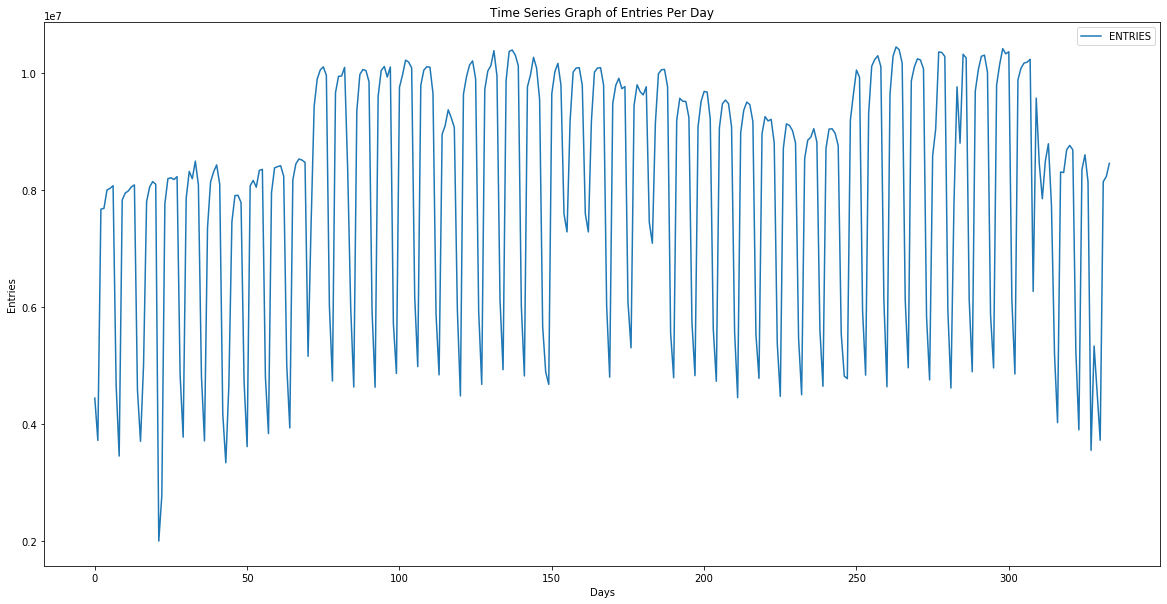

In [16]:
fig_dims = (20, 10)
plot = train_data[['ENTRIES', 'DATE']].plot(title = 'Time Series Graph of Entries Per Day', figsize = fig_dims)
plot.set_xlabel('Days')
plot.set_ylabel('Entries')

Text(0.5, 1.0, 'Average Entries Per Weekday')

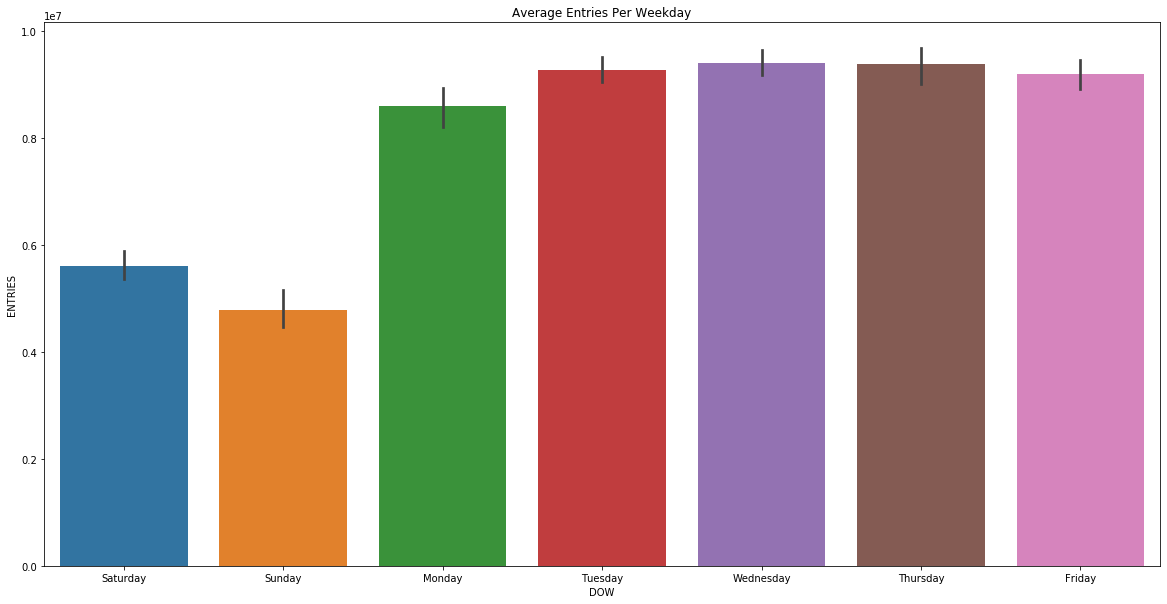

In [17]:
fig, ax = plt.subplots(figsize=fig_dims)
plot = sns.barplot(x = train_data.DOW, y = train_data.ENTRIES, ax = ax)
plot.set_title('Average Entries Per Weekday')

Text(0.5, 1.0, 'Average Entries Per MONTH')

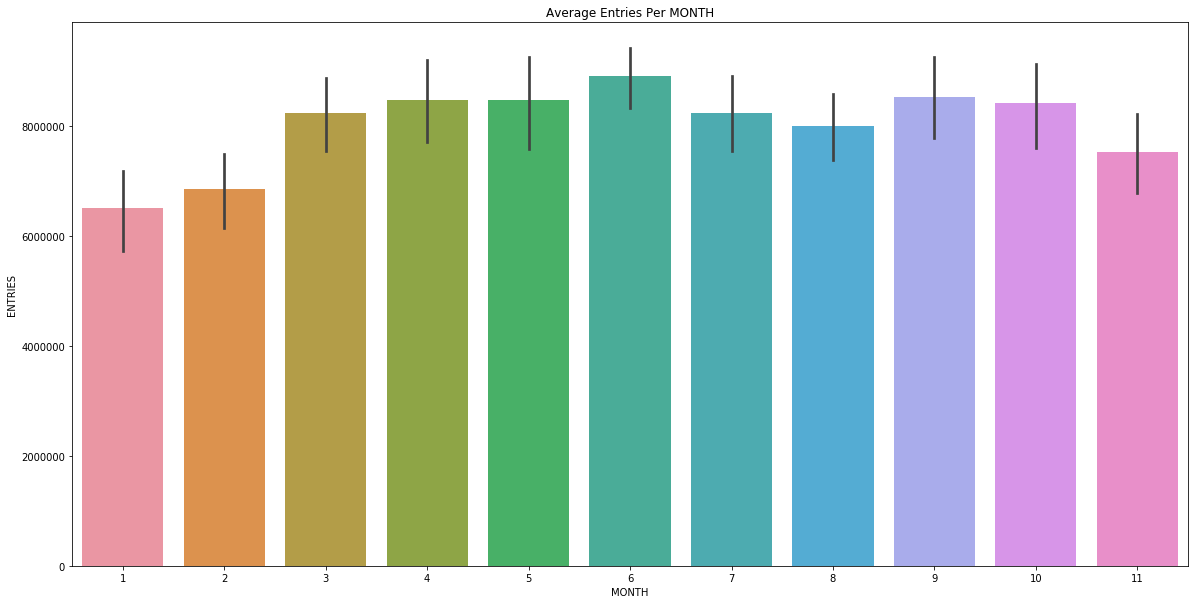

In [18]:
fig, ax = plt.subplots(figsize=fig_dims)
plot = sns.barplot(x = train_data.MONTH, y = train_data.ENTRIES, ax = ax)
plot.set_title('Average Entries Per MONTH')

The above two graphs show three important aspects of this time series. One there does not seem to be an obvious trend to this data, meaning that the number of entries does not seem to dramatically increase or decrease in a monotonic way. Rather, there seems to be weekly seasons in the dataset. Particularly Saturdays and Sundays seem to have less people taking the subway.

Also, one possible observation to make from these plots is that months with multiple holidays or breaks have less usage of the subways. We can think of this as summer effect for summer break or winter effect for the several holidays that occur between late November and mid February.

Below, we observe the month by month plots of entries for each day of a given month, where Month 1 denotes January and Month 11 denotes November. We see here that weekends again have much lower subway ridership, with erratic months, like November, having a lot of holidays that contribute to lower ridership. This could signal erratic behavior in December as well.

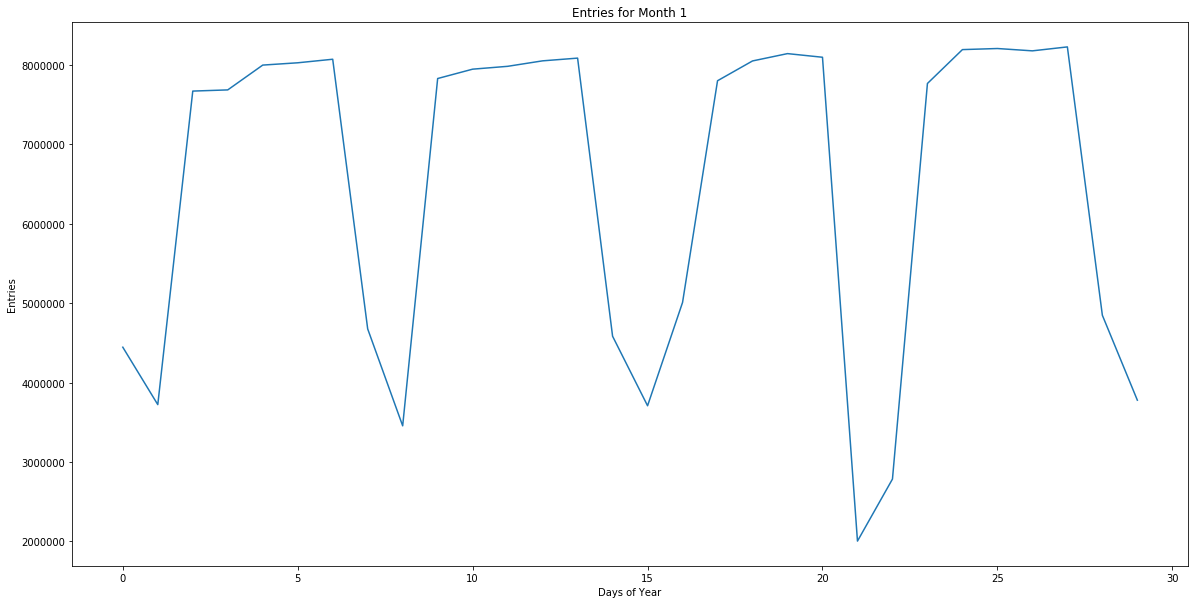

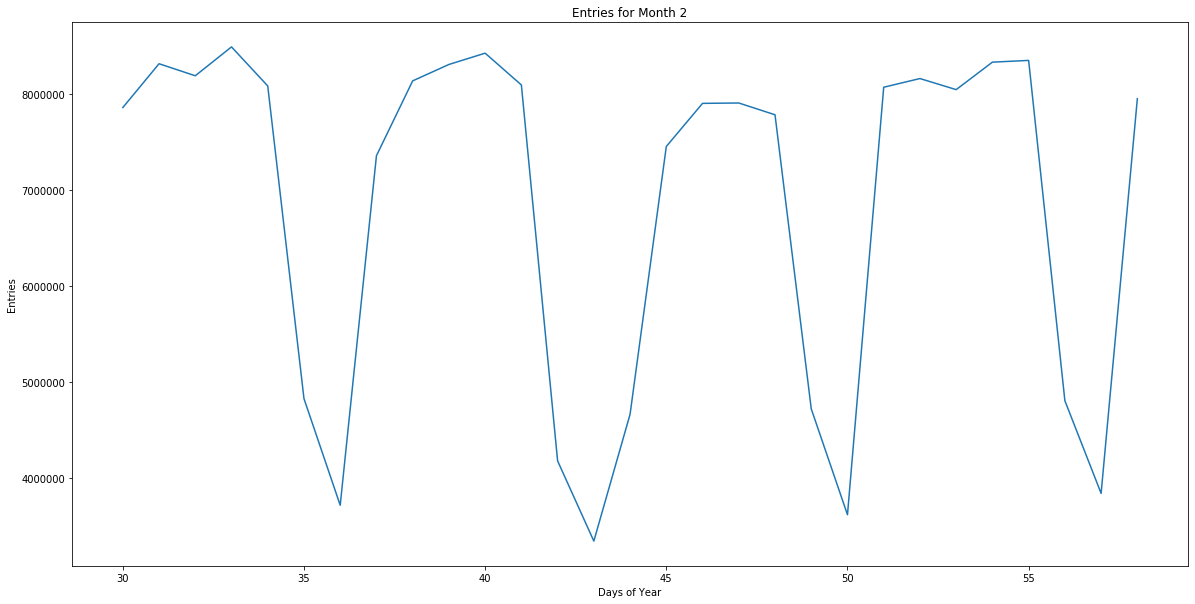

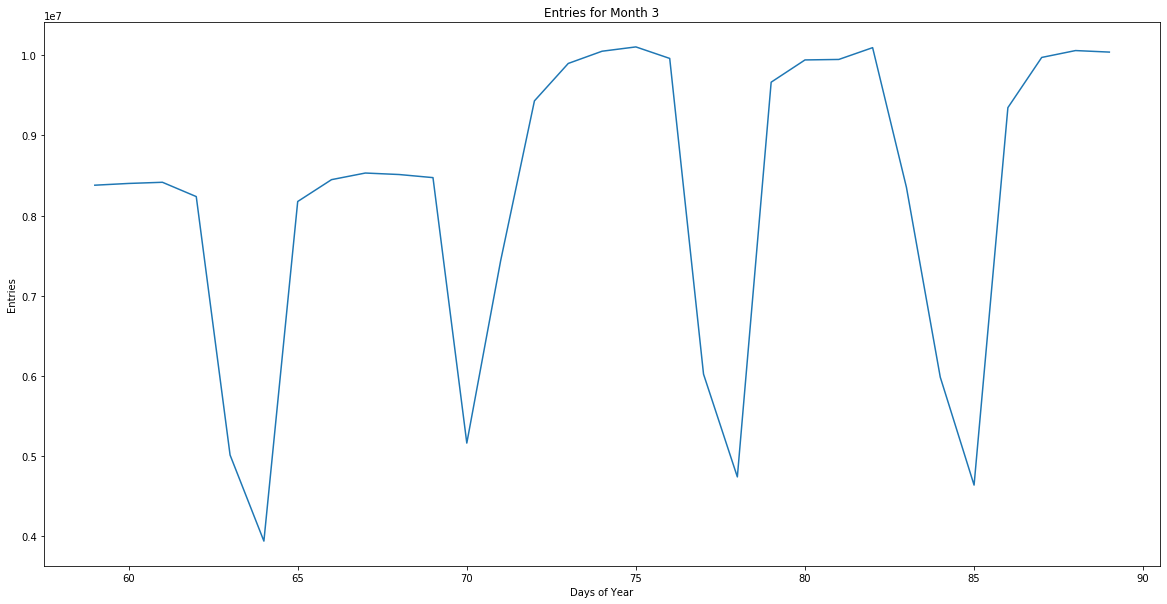

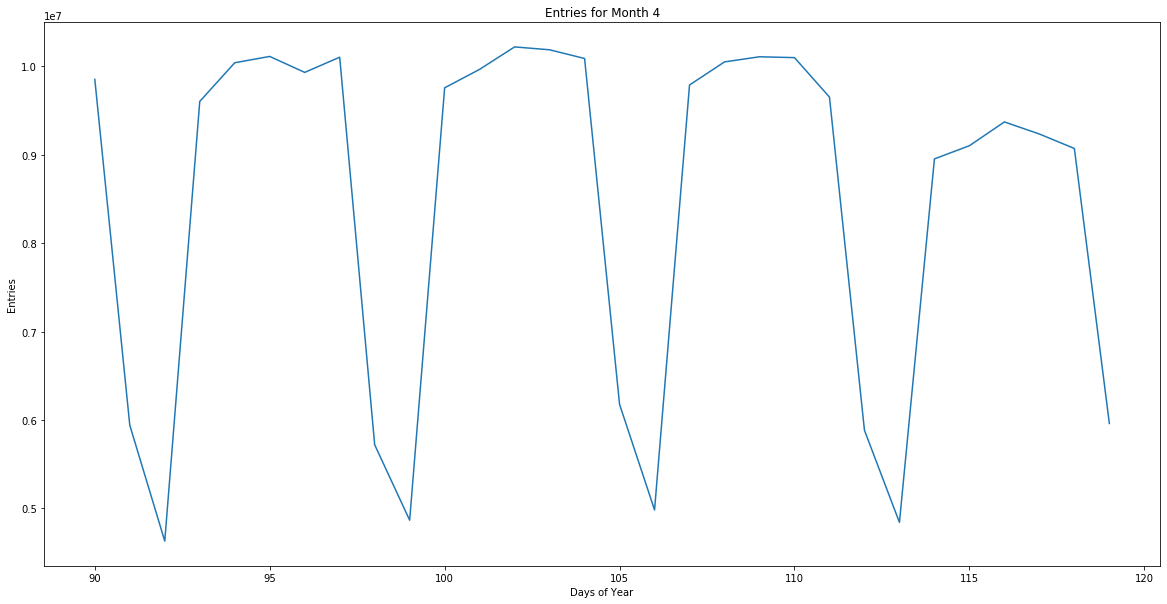

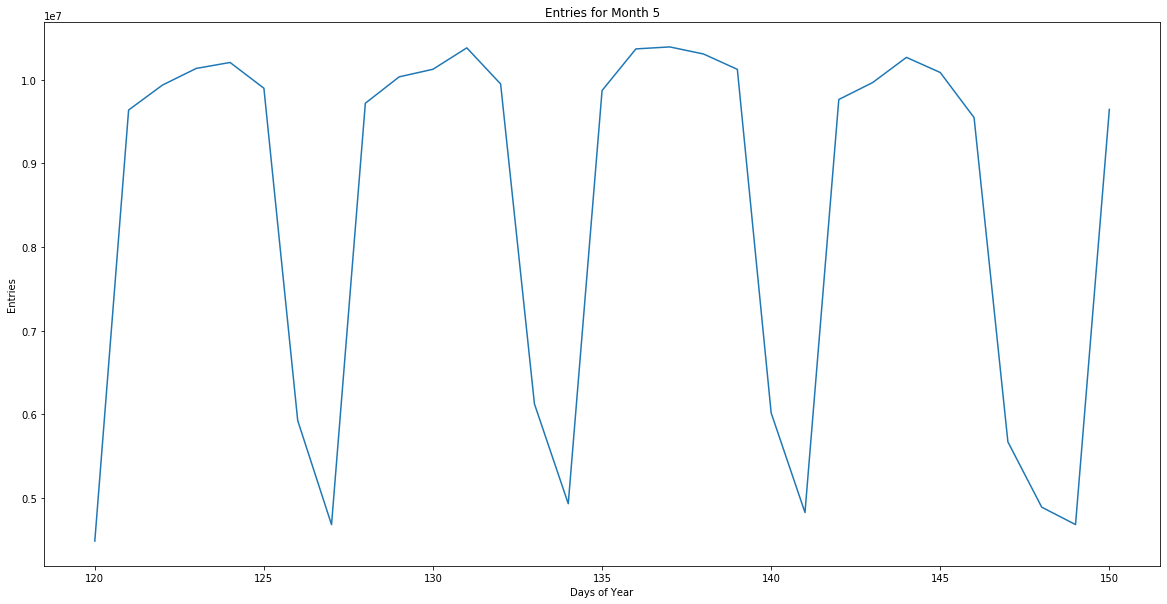

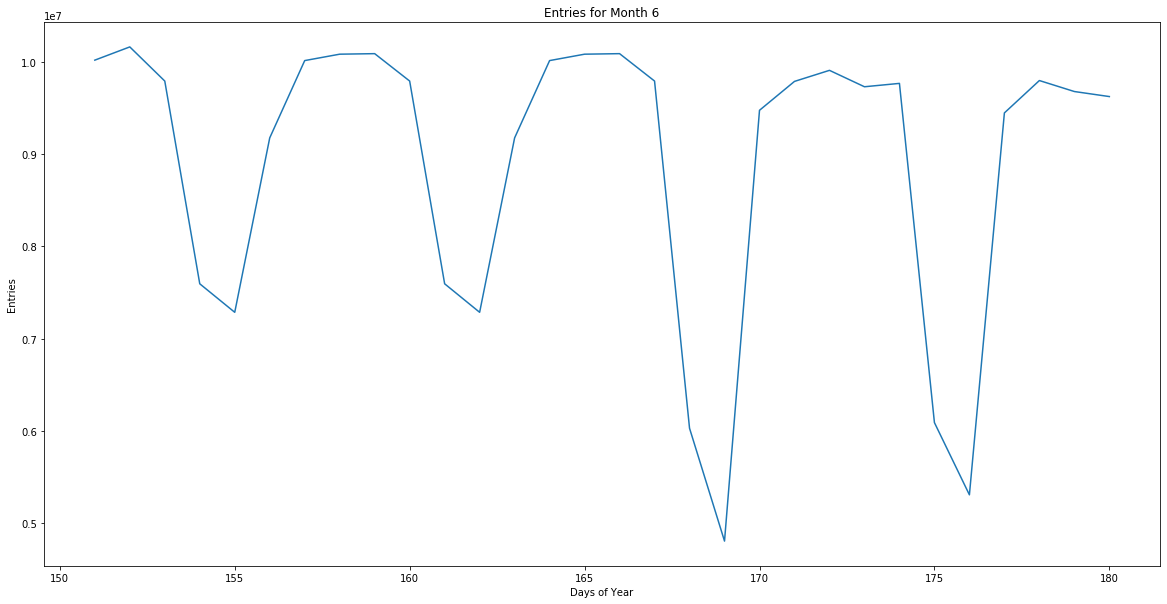

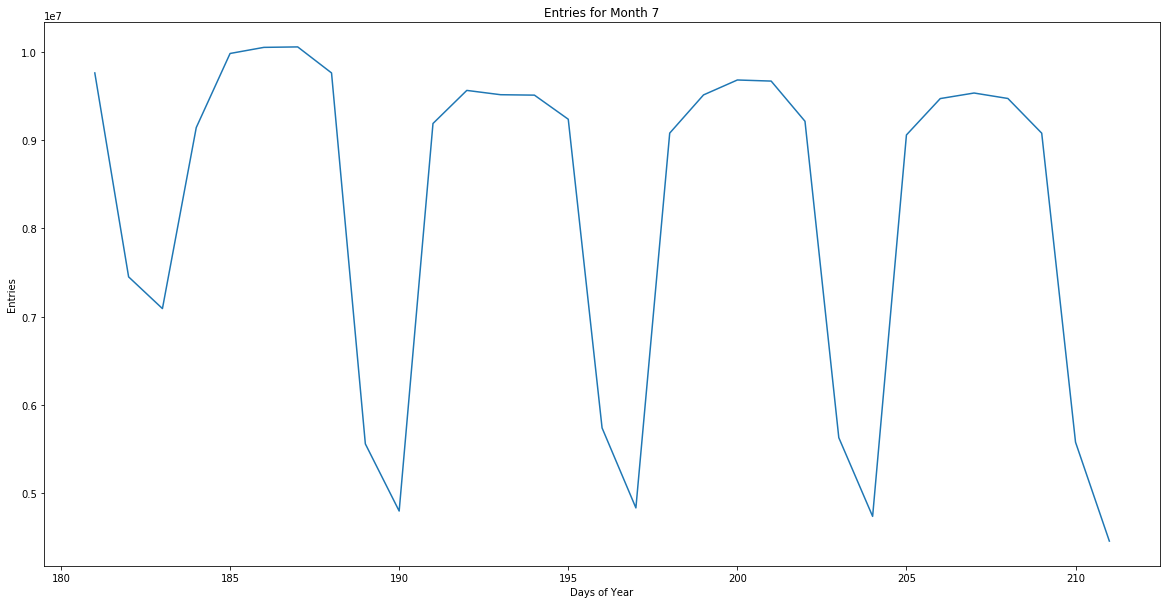

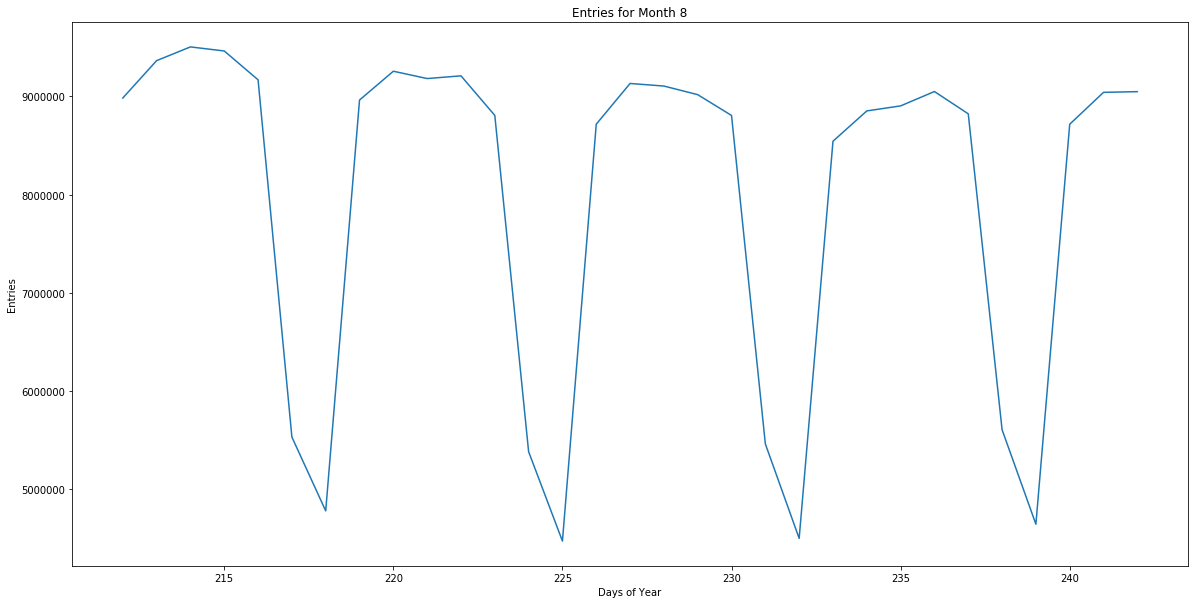

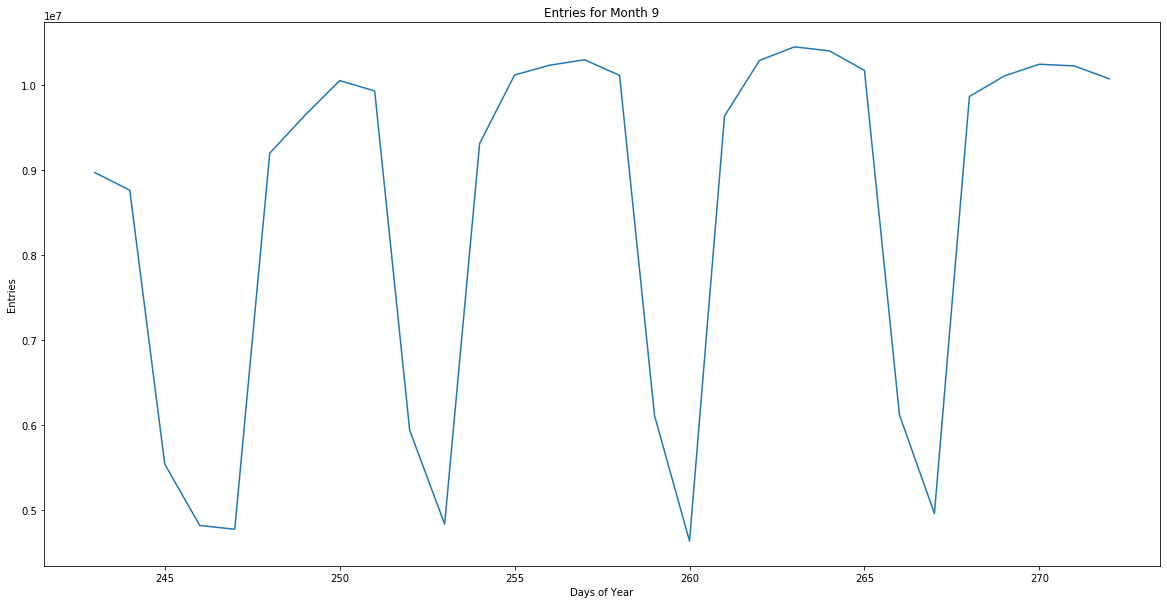

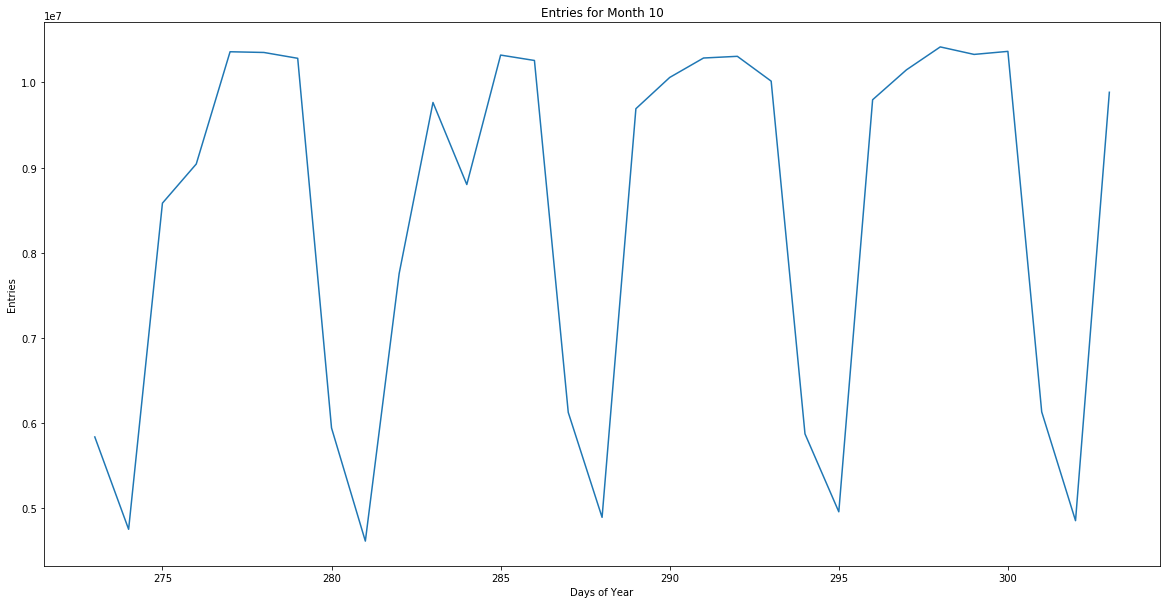

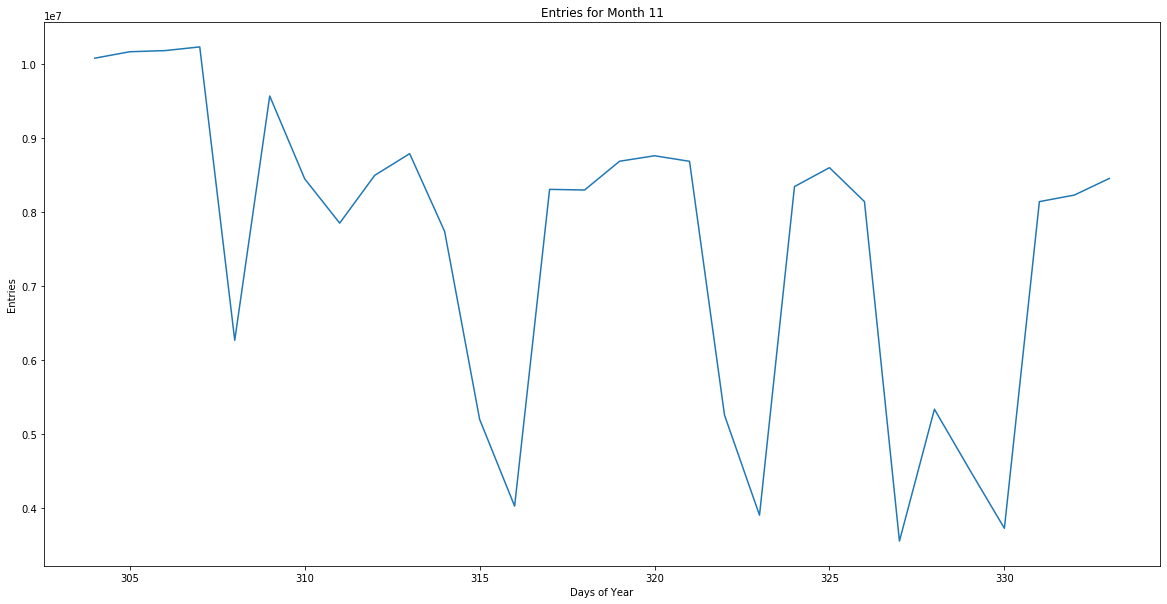

In [19]:
for month in list(train_data['MONTH'].unique()):
    plot = train_data[train_data['MONTH'] == month][['ENTRIES', 'DATE']].plot(title = "Entries for Month {}".format(month), 
                                                                              figsize = fig_dims,
                                                                              legend = False)
    plot.set_xlabel('Days of Year')
    plot.set_ylabel('Entries')

Below, we observe two important statistical tests/graphs that will tell us about our time series. We see from the autocorrelation graph, correlating the first entry in the time series with the lags. The graph tells us that many of the lag values have correlations that are statistically significant, which means our data is highly correlated, something we want to dampen as we make our time series stationary.

And we know that this time series is not stationary thanks to the Augmented Dickey Fuller Test. We judge the test by seeing whether the critical values are less than the test statistic. If the test statistic is less than the critical values, we can say, with some defined threshold for the p-value, that we reject the null hypothesis that the time series is non-stationary. If the test statistic is greater than the critical values, then we must say that we cannot reject the null hypothesis, so our time series is most probably non-stationary. In our case, we have a test statistic that is greater than each of the critical values, and thus we cannot say with confidence that this time series is stationary.

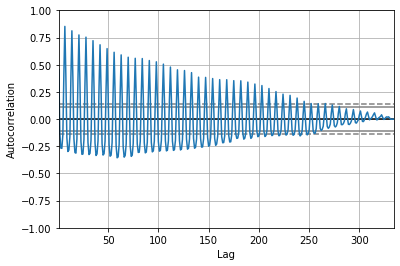

In [20]:
autocorrelation_plot(train_data['ENTRIES'])

In [21]:
def adfuller_stats(data):
    """
    Writes out statistics from the Augmented Dickey-Fuller test.
    """
    results = adfuller(data[['ENTRIES']], autolag='AIC')
    print('Test Statistic: {}'.format(results[0]))
    print('p-value: {}'.format(results[1]))
    print('Number of Lags Used: {}'.format(results[2]))
    print('Number of Observations Used: {}'.format(results[3]))
    for key in results[4].keys():
        print('Critical value {}: {}'.format(key, results[4][key]))

In [22]:
adfuller_stats(train_data)

Test Statistic: -2.32614266053897
p-value: 0.16367500074363905
Number of Lags Used: 17
Number of Observations Used: 316
Critical value 1%: -3.4512146067362317
Critical value 5%: -2.870730188960711
Critical value 10%: -2.5716664849383113


## Transforming the Time Series

Now that we have explored the time series and learned some key pieces of information, we are now ready to try to transform the data a bit to see if we can get it to a stationary state. We first transform the data by applying the logarithm and box-cox transform to each entry. Next we do an exponetially moving average to remove any unknown trends or seasonal effects. Then we will take out the seasonality from the dataset by taking the mean for each weekday over the course of the given year and subtracting that the data. Lastly, we'll remove the holiday effect, by taking the average of the days that are holidays and are not holidays and then subtract those away from the respective days. Throughout, we will see the affect of each transformation, and determine which ones are most important for our modeling efforts.

We will do this systematically, by first applying each transformation to the original time series dataset, and then see if combining effective methods will yield better results.

In [23]:
transformed_values = boxcox(train_data['ENTRIES'].values)
transformed_array = transformed_values[0]
transformed_lambda = transformed_values[1]
box_cox_series = train_data.copy()
box_cox_series['ENTRIES'] = pd.Series(transformed_array)
transformed_lambda

2.388657933698321

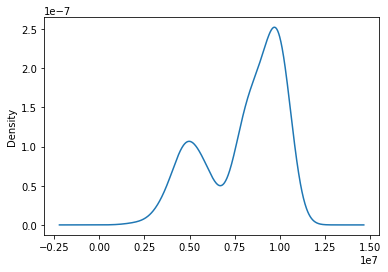

In [24]:
train_data['ENTRIES'].plot(kind = 'density')

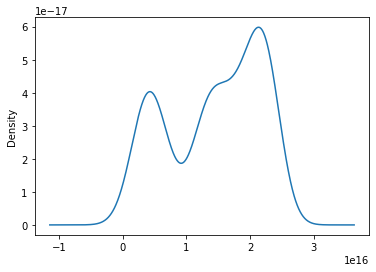

In [25]:
box_cox_series['ENTRIES'].plot(kind = 'density')

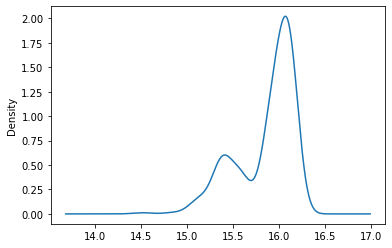

In [26]:
train_data['ENTRIES'].apply(log).plot(kind = 'density')

Notice that neither the box-cox transform nor the logarithm were able to get rid of the bimodal nature of the distribution we have. Thus, we will ignore using either transformation, and hope one of the below techniques will remedy this situation.

In [27]:
exp_ma = train_data[['ENTRIES']].ewm(span = 7).mean()
diff_expma = train_data[['ENTRIES']] - exp_ma
adfuller_stats(diff_expma)

Test Statistic: -4.605109951979839
p-value: 0.00012639714979097285
Number of Lags Used: 13
Number of Observations Used: 320
Critical value 1%: -3.450951662384033
Critical value 5%: -2.8706147570800784
Critical value 10%: -2.571604931640625


As we can see above, with incredibly high confidence, taking an exponential moving average seems to make the dataset stationary. This will be one of the techniques we use when developing features and fitting our model.

In [28]:
def create_mean_per_weekday(data):
    """
    One of the effects we saw in our exploration in the data is seasonality. To capture the weekly seasonality, we take
    the mean of each day of the week (DOW) over the course of the entire dataset.
    """
    mean_dow = data[['DOW', 'ENTRIES']].groupby('DOW').mean()
    dow_means = []
    for day1 in list(data['DOW']):
        for day2 in list(mean_dow.index):
            if day1 == day2:
                dow_means.append(mean_dow['ENTRIES'][day2])
    return pd.DataFrame(dow_means, columns = ['DOW_MEAN'])

In [29]:
means_dow_df = create_mean_per_weekday(train_data)
diff_means_dow = train_data['ENTRIES'] - means_dow_df['DOW_MEAN']
diff_means_dow = pd.DataFrame(diff_means_dow, columns = ['ENTRIES'])
adfuller_stats(diff_means_dow)

Test Statistic: -2.351601811009129
p-value: 0.15586472778867522
Number of Lags Used: 7
Number of Observations Used: 326
Critical value 1%: -3.4505694423906546
Critical value 5%: -2.8704469462727795
Critical value 10%: -2.5715154495841017


As we can see above, the mean of each weekday does not seem to account for the seasonality we see. However, it may still be useful, as the test statistic is close to the 10% critical value. Possibly, combining it with the exponential moving window, can increase the quality of our results.

In [30]:
def create_holiday_means(data):
    means = data[['HOLIDAY', 'ENTRIES']].groupby('HOLIDAY').mean()
    holiday_means = []
    for holiday in list(data['HOLIDAY']):
        if holiday == 1:
            holiday_means.append(means['ENTRIES'][1])
        else:
            holiday_means.append(means['ENTRIES'][0])
    return pd.DataFrame(holiday_means, columns = ['HOLIDAY_MEAN'])

In [31]:
holiday_means = create_holiday_means(train_data)
diff_holiday_means = train_data['ENTRIES'] - holiday_means['HOLIDAY_MEAN']
diff_holiday_means = pd.DataFrame(diff_holiday_means, columns = ['ENTRIES'])
adfuller_stats(diff_holiday_means)

Test Statistic: -1.8440265167534586
p-value: 0.3588330253670643
Number of Lags Used: 14
Number of Observations Used: 319
Critical value 1%: -3.4510167751522642
Critical value 5%: -2.87064334231426
Critical value 10%: -2.5716201744283174


As we can see above, taking away holiday averages barely effected our dataset, showing that holidays do not contribute a huge amount to whether the dataset is stationary or not. Thus, we will not be using it when we combine techniques.

Since the exponential moving average had the greatest results in making our dataset stationary, we will apply taking weekday means away from the already transformed dataset by the exponential moving average.

In [32]:
new_time_series1 = train_data.copy()
new_time_series1['ENTRIES'] = diff_expma['ENTRIES']
means_dow_expma = create_mean_per_weekday(new_time_series1)
diff_means_dow_expma = new_time_series1['ENTRIES'] - means_dow_expma['DOW_MEAN']
diff_means_dow_expma = pd.DataFrame(diff_means_dow_expma, columns = ['ENTRIES'])
adfuller_stats(diff_means_dow_expma)

Test Statistic: -15.078749694315281
p-value: 8.514946160956115e-28
Number of Lags Used: 0
Number of Observations Used: 333
Critical value 1%: -3.450141065277327
Critical value 5%: -2.870258846235788
Critical value 10%: -2.571415151457764


Combining the two techniques described above has increased our results massively. Thus, we can now be confident that we have a stationary time series. These two techniques, subtracting the mean of the weekdays and subtracting the exponetial moving average of the time series, will be included in our feature engineering design.

The last thing we need to do is determine the number of lags we need when designing our models.

(0, 5)

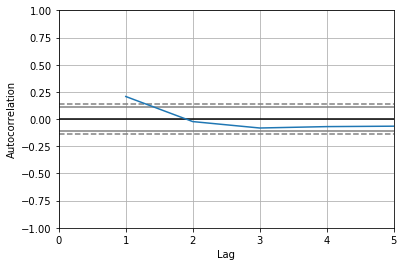

In [33]:
ax = autocorrelation_plot(diff_means_dow_expma['ENTRIES'])
ax.set_xlim([0,5])

Above is a truncated version of the autocorrelation graph. Now, for many of our lags, we do not see high levels of correlation. It seems like 1 lag would be a good amount to use when developing an ARIMA model, as it will provide the most correlated variables according to this graph. However, when developing a machine learning model, as the ENTRIES will not undergo any transformations, 7 lags will probably be most beneficial to account for seasonality.

## Developing Our Models

We will try to model this data in two different ways. One way will be with an ARIMA model, and the other will be with XGBoost. ARIMA is a classic model that uses moving averages (MA), autoregression (AR), and integral (I) methods to model our time series in a linear fashion. XGBoost has been used in many kaggle competitions when dealing with time series data, which is why it was chosen as the model for this challenge.

If given more time and more data, an LSTM or a state based model may also be effective. However, an LSTM was not chosen this time for two reasons: 1) even if we got more data from past years datasets, I do not think it would be enough to train the LSTM and 2) due to the time sensitive nature of this challenge, and the prompt saying model performance is not what is being tested, I determined that LSTM is also not an efficient algorithm at this time. If given the opportunity to work on this data further, I would probably grab more data and work on an LSTM.

In [34]:
arima_model_data = train_data.copy()
arima_model_data['ENTRIES'] = diff_means_dow_expma['ENTRIES']
normaltest(arima_model_data['ENTRIES'])

NormaltestResult(statistic=122.44107644061393, pvalue=2.583795108840764e-27)

                              ARMA Model Results                              
Dep. Variable:                ENTRIES   No. Observations:                  334
Model:                     ARMA(1, 0)   Log Likelihood               -4887.589
Method:                           css   S.D. of innovations         572922.752
Date:                Wed, 19 Feb 2020   AIC                           9781.178
Time:                        16:41:43   BIC                           9792.603
Sample:                             1   HQIC                          9785.734
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.363e-10   3.96e+04  -3.44e-15      1.000   -7.77e+04    7.77e+04
ar.L1.ENTRIES     0.2078      0.052      3.966      0.000       0.105       0.310
                                    Root

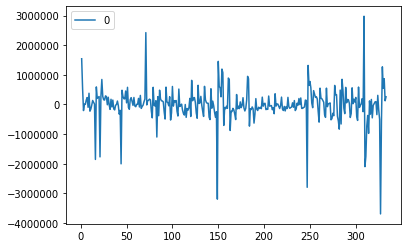

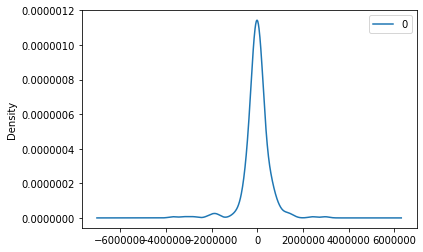

                  0
count  3.330000e+02
mean  -6.678844e+03
std    5.737459e+05
min   -3.695640e+06
25%   -1.742141e+05
50%   -1.119661e+04
75%    1.995044e+05
max    2.977226e+06


In [35]:
model = ARIMA(arima_model_data[arima_model_data['MONTH'] < 12]['ENTRIES'], order=(1,0,0))
model_fit = model.fit(disp=0,  method = 'css')
print(model_fit.summary())
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [36]:
zscores = zscore(residuals)
zscores = pd.DataFrame(zscores, columns = ['Z-SCORES'])
residuals = residuals.reindex([i for i in range(334)])
res_zs = pd.concat([residuals, zscores], axis = 1)
res_zs = res_zs.dropna()
res_zs = res_zs[res_zs['Z-SCORES'] < 3]
normaltest(res_zs[0])

NormaltestResult(statistic=138.4387515030972, pvalue=8.67774872252113e-31)

Let's walk through what has happened above. We fit an ARIMA model to the months January to November. Then we looked at the residuals of the ARIMA model and found that they are not normally distributed. This means that when the ARIMA optimizes, using MLE or CSS, it won't be operating on normally distributed values. Thus, the ARIMA estimations may be off. Moreover, we can see by the mean not being 0 that there is some bias in the ARIMA model. Therefore, we move forward to training an XGBoost model.

Below we start by building features for the XGBoost model. They will be similar in flavor to the important structures we found in the data exploration phase, such as capturing the seasonality with the exponential moving average and the average for each day of the week, capturing the holidays within the year (although not significant in Dickey Fuller Tests, it still may give a signal), and providing what month we are in.

In [37]:
def create_lag_columns(data, num):
    """
    The purpose of this function is to create lag features for our dataset. Since we are dealing with time series data,
    understanding the past is crucial. You pass in data and the number of lags you want, and ti creates a new dataframe
    that has the lags.
    """
    series = []
    columns = []
    for i in range(num):
        series.append(data['ENTRIES'].shift(i+1))
        columns.append('LAG{}'.format(i+1))
        
    series_df = pd.concat(series, axis = 1)
    series_df.columns = columns
        
    return pd.concat([data, series_df], axis = 1).fillna(0)

In [38]:
def weekend(data):
    """
    During our model building, I noticed that each day doesn't contribute much, but that possibly the difference between
    weekday and weekend could contribute some signal. So I created a function to creat a binary column to indicate
    whether a day was a weekend or not.
    """
    weekend_binary = []
    for index, row in data.iterrows():
        if (row['Saturday'] == 1) or (row['Sunday'] == 1):
            weekend_binary.append(1)
        else:
            weekend_binary.append(0)
    return weekend_binary

In [39]:
def incremental_prediction(test_data, feature_dev_data, regression):
    """
    To prevent data leakage and accurately predict each day, I built a function that creates features that are dependent
    on the past for each new test_data point. This allows the features to incorporate the predictions for the model,
    instead of relying on the already known data points for December 2016.
    
    What this function does is take in a test_data set and a feature_dev_data set (usually the training data set) and
    calculates the following features using the training data set appended with the next test_data point to be predicted:
    
    1) Calculates the lag features.
    2) Calculates the exponential moving average.
    3) Calculates the mean for the day of the week.
    
    The test_data should already have binary columns for holiday and weekend, and a column for the month. The above should
    be all that needs to be calculated, as this function only calculates the features that are dependent on the past and
    not the present.
    
    Then the function predicts using a trained regression model (in this case an xgboost model, but any model can be used).
    That prediction is then appended to the ENTRIES column for the test_data that was predicted on. This initializes a
    for loop that does the same actions as stated above.
    
    The output of this function is a list of predictions.
    """
    
    #First iteration of data preparation for test data points
    test_array = test_data.values
    feature_dev_data = pd.concat([feature_dev_data, pd.DataFrame([test_array[0]], columns = test_data.columns)]).reset_index()
    feature_dev_data = feature_dev_data.drop(['index'], axis = 1)
    add_lag = create_lag_columns(feature_dev_data, 7)
    add_lag['EXPMA'] = add_lag['ENTRIES'].ewm(span = 7).mean()
    add_lag['DOW_MEAN'] = create_mean_per_weekday(add_lag)
    predict_df = add_lag.drop(['DATE', 'DOW', 'ENTRIES'], axis = 1)
    
    #First iteration of predictions for test data points
    prediction = regression.predict([predict_df.values[-1]])
    predictions = [int(prediction[0])]
    entries = list(feature_dev_data['ENTRIES'])
    entries.pop()
    entries.append(int(prediction[0]))
    feature_dev_data['ENTRIES'] = entries
    
    #The first iteration already done, we are now able to loop through the rest of the data and calculate values
    #using the models predictions
    for i in range(1, len(test_array)):
        feature_dev_data = pd.concat([feature_dev_data, pd.DataFrame([test_array[i]], columns = test_data.columns)]).reset_index()
        feature_dev_data = feature_dev_data.drop(['index'], axis = 1)
        add_lag = create_lag_columns(feature_dev_data, 7)
        add_lag['EXPMA'] = add_lag['ENTRIES'].ewm(span = 7).mean()
        add_lag['DOW_MEAN'] = create_mean_per_weekday(add_lag)
        predict_df = add_lag.drop(['DATE', 'DOW', 'ENTRIES'], axis = 1)
        prediction = regression.predict([predict_df.values[-1]])
        predictions.append(int(prediction[0]))
        entries.append(int(prediction[0]))
        feature_dev_data['ENTRIES'] = entries
    
    return predictions

In [40]:
time_series_lag = create_lag_columns(train_data, 7)
time_series_lag['EXPMA'] = exp_ma
time_series_lag['DOW_MEAN'] = means_dow_df
one_hot_dow = pd.get_dummies(time_series_lag['DOW'])
time_series = pd.concat([time_series_lag, one_hot_dow], axis = 1)

In [41]:
xgboost_train_labels = time_series['ENTRIES']
xgboost_train = time_series.drop(['ENTRIES', 'DATE', 'DOW'], axis = 1)
xgboost_test_labels = test_data['ENTRIES']
xgboost_test = test_data.drop(['ENTRIES', 'DATE'], axis = 1)

We notice below that importance of the features representing day of week does not contribute much to the model. Although these features do not seem important now, we will still assess whether this will work better as a binary variable to check if a day is a weekeend or not.

[16:41:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


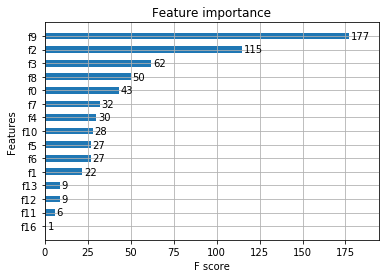

In [42]:
regression = xgb.XGBRegressor()
regression.fit(xgboost_train.values, xgboost_train_labels.values)
plot_importance(regression, height = .5) 

In [43]:
xgboost_train['WEEKEND'] = weekend(xgboost_train)
xgboost_train = xgboost_train.drop(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], axis = 1)

#Reorganizes the schema, so that the train and test sets match.
xgboost_train = xgboost_train[['MONTH', 'HOLIDAY', 'WEEKEND', 'LAG1', 'LAG2', 'LAG3', 'LAG4', 'LAG5', 'LAG6', 'LAG7', 'EXPMA', 'DOW_MEAN']]

We now see that the feature discussing the mean of each day through the year does not seem to be a very important feature. However, due to experimentation, DOW_MEAN does have an effect on our metric of success. So we keep the feature.

[16:41:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


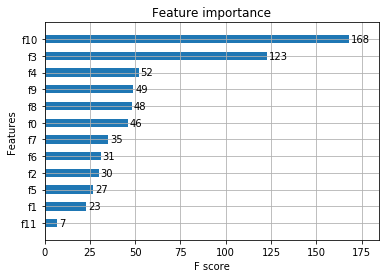

In [44]:
regression.fit(xgboost_train.values, xgboost_train_labels.values)
plot_importance(regression, height = .5)

In [45]:
xgboost_test = xgboost_test.reset_index().drop(['index'], axis = 1)
one_hot_dow = pd.get_dummies(xgboost_test['DOW'])
xgboost_test = pd.concat([xgboost_test, one_hot_dow], axis = 1)
xgboost_test['WEEKEND'] = weekend(xgboost_test)
xgboost_test = xgboost_test.drop(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], axis = 1)

In [46]:
predictions = incremental_prediction(xgboost_test, train_data, regression)
predictions = pd.concat([xgboost_test_labels.reset_index(), pd.DataFrame(predictions, columns = ['PREDS'])], axis = 1)
predictions = predictions.drop(['index'], axis = 1)

We see below two metrics of success. One is a graph of our predictions superimposed on our test set. The graph shows the model has pickd up on daily trends, but hasn't been able to pick up on the variations from week to week. This could be telling us that we should increase the window size for our lags. When increasing the window size to 14 lags, we find that we get very similar results. But if we decrease to less than 7 lags, we start getting far worse results.

We also use Root Mean Squared Error. This is telling us that we are missing about 1.7 million people on average, but considdering that we have entries per day that are upwards of 10 million, this is okay for a first try at the model. Putting it into even greater perspective, we can see by the graph that our error is particularly bad on some days, skewing the possible discrepency we are seeing.

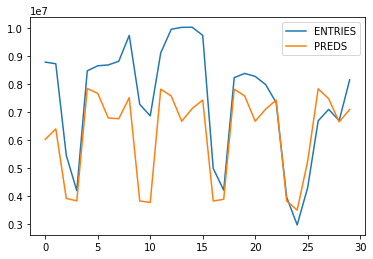

RMSE: 1762489.4411745658


In [47]:
predictions.plot()
plt.show()
rmse = sqrt(mse(list(predictions['ENTRIES']), list(predictions['PREDS'])))
print('RMSE: {}'.format(rmse))